In [1]:
import wandb
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# font size to 10
matplotlib.rcParams['font.size'] = 10

api = wandb.Api()

# Loss and Correlation

In [2]:
run_ids = {
    'life': 'fx9q3zj2',
    'waves': '5vfulil3',
    'spirals': 'h8m0brgw'
}

histories = {k: api.run("yanbozhang/pattern-to-dynamics/" + v).history(samples=10000) for k, v in run_ids.items()}

In [3]:
def ema(data, beta=0.99):
    ema_data = []
    for i, x in enumerate(data):
        if i == 0:
            ema_data.append(x)
        else:
            ema_data.append(beta * ema_data[-1] + (1 - beta) * x)
    return ema_data

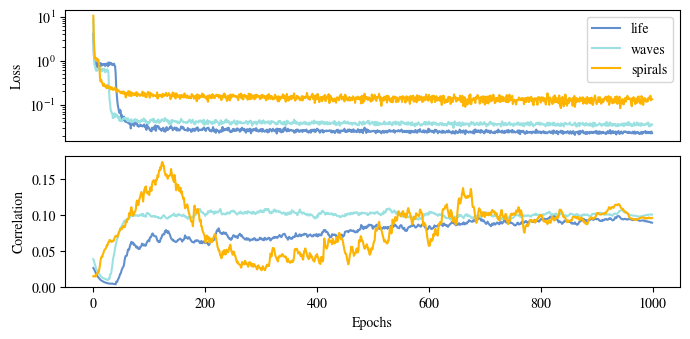

In [174]:
fig = plt.figure(figsize=(7, 3.5))

colors = ['#628FCE', '#9BE1E1', '#FEB400']

# Use 2x1 grid

plt.subplot(2, 1, 1)
for i, (name, history) in enumerate(histories.items()):
    history['epoch_int'] = history['epoch'].astype(int)
    history = history.groupby('epoch_int').mean().reset_index()
    plt.plot(history['loss'], label=name, color=colors[i])
# plt.xlabel('Epochs')
plt.ylabel(r'Loss')
# plt.title('Training Loss')
# set y axis to log
plt.yscale('log')
plt.xticks([])
plt.legend()

plt.subplot(2, 1, 2)

for i, (name, history) in enumerate(histories.items()):
    history['epoch_int'] = history['epoch'].astype(int)
    history = history.groupby('epoch_int').mean().reset_index()
    plt.plot(ema(abs(history['corr']), beta=0.9), label=name, color=colors[i])
plt.xlabel('Epochs')
plt.ylabel('Correlation')
# plt.title('Training Correlation')
plt.ylim(0, None)

plt.tight_layout()
plt.savefig('./figures/correlation.pdf', bbox_inches='tight')
plt.show()

# Simulation Results

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from train_dynamics import FlowModel
from train_dynamics import load_score_model
from turing_pattern import GrayScottSimulator, create_random_state, TuringPatternDataset
from tqdm import tqdm

In [3]:
def score_function(unet, scheduler, t):
    def score_model(xt):
        model_output = unet(xt, t)
        x0 = scheduler.step(model_output.sample, t, xt).pred_original_sample
        alpha_t = scheduler.alphas_cumprod[t]
        score = (x0 * alpha_t ** 0.5 - xt) / (1 - alpha_t)
        return score

    return score_model

def load_models(name: str, use_bn: bool = False):
    dataset = TuringPatternDataset.load(f'./turing_pattern/data/{name}_128x128.pt')
    score_model, scheduler = load_score_model(name, device='cuda')

    flow_model = FlowModel(use_bn=use_bn).cuda()
    flow_model.load_state_dict(torch.load(f'./turing_pattern/flow_models/{name}.pth', map_location='cuda'))
    flow_model.eval()

    return dataset, score_model, scheduler, flow_model

In [4]:
@torch.no_grad()
def simulate(x, score_model, flow_model, scheduler, T=500, dt=0.01, eta=1.0, t=10, v_factor=1.0, batch=64):
    trace = []
    trace_pred = []

    score_model.eval().cuda()
    flow_model.eval()

    t = torch.LongTensor([t]).cuda()
    x = scheduler.add_noise(x, torch.randn_like(x), t)
    std0 = x.std().item()
    min0 = x.min().item()
    max0 = x.max().item()

    sf = score_function(score_model, scheduler, t.item())

    for i in tqdm(range(T)):
        eps = score_model(x, t).sample
        trace.append(x.cpu())

        v = flow_model(x) * v_factor
        v = v / v.norm(dim=1).mean()
        v = v - v.mean()
        # v = v / (v.std(dim=(1, 2), keepdim=True) + 1e-6)
        s = sf(x)
        x = x + (v + eta * s) * dt + ((2 * eta * dt) ** 0.5) * torch.randn_like(x)
        # x = x / (x.std() + 1e-3) * std0 # keep the initial standard deviation
        x = (x - x.min()) / (x.max() - x.min()) * (max0 - min0) + min0 # keep the initial range

    trace = torch.stack(trace, dim=0)

    for i in tqdm(range(len(trace) // batch + 1)):
        trace_batch = trace[i*batch:(i+1)*batch, 0]
        x_pred = trace_batch.cuda()
        sample = score_model(x_pred, t.item()).sample
        x_pred = scheduler.step(sample, t.item(), x_pred).pred_original_sample
        # for tau in range(t.item(), 0, -1):
        #     sample = score_model(x_pred, tau).sample
        #     x_pred = scheduler.step(sample, tau, x_pred).prev_sample
        trace_pred.append(x_pred.cpu().clamp(-1, 1))
    trace_pred = torch.cat(trace_pred, dim=0)
    return trace, trace_pred.unsqueeze(1)

In [17]:
@torch.no_grad()
def simulate(x, score_model, flow_model, scheduler, T=500, dt=0.01, eta=1.0, t=10, v_factor=1.0, batch=64):
    trace = []
    trace_pred = []

    score_model.eval().cuda()
    flow_model.eval()

    t = torch.LongTensor([t]).cuda()
    x = scheduler.add_noise(x, torch.randn_like(x), t)
    std0 = x.std().item()
    min0 = x.min().item()
    max0 = x.max().item()

    sf = score_function(score_model, scheduler, t.item())
    a = lambda x: flow_model(x) * v_factor + eta * sf(x)

    for i in tqdm(range(T)):
        eps = score_model(x, t).sample
        trace.append(x.cpu())

        # v = flow_model(x) * v_factor
        # v = v / v.norm(dim=1).mean()
        # v = v - v.mean()
        # v = v / (v.std(dim=(1, 2), keepdim=True) + 1e-6)
        # s = sf(x)
        epsilon = torch.randn_like(x)
        x_hat = x + a(x) * dt + ((2 * eta * dt) ** 0.5) * epsilon
        x = x + (a(x) + a(x_hat)) / 2 * dt + ((2 * eta * dt) ** 0.5) * epsilon

        # x = x + (v + eta * s) * dt + ((2 * eta * dt) ** 0.5) * torch.randn_like(x)
        # x = x / (x.std() + 1e-3) * std0 # keep the initial standard deviation
        # x = (x - x.min()) / (x.max() - x.min()) * (max0 - min0) + min0 # keep the initial range

    trace = torch.stack(trace, dim=0)

    for i in tqdm(range(len(trace) // batch + 1)):
        trace_batch = trace[i*batch:(i+1)*batch, 0]
        x_pred = trace_batch.cuda()
        sample = score_model(x_pred, t.item()).sample
        x_pred = scheduler.step(sample, t.item(), x_pred).pred_original_sample
        # for tau in range(t.item(), 0, -1):
        #     sample = score_model(x_pred, tau).sample
        #     x_pred = scheduler.step(sample, tau, x_pred).prev_sample
        trace_pred.append(x_pred.cpu().clamp(-1, 1))
    trace_pred = torch.cat(trace_pred, dim=0)
    return trace, trace_pred.unsqueeze(1)

In [5]:
class TuringPlotter:
    RANGES = {
        'life': [(0.13, 1), (0, 0.33)],
        'waves': [(0.12, 1), (0, 0.42)],
        'spirals': [(0.05, 0.7), (0, 0.37)],
        'maze': [(0.2, 0.8), (0, 0.35)]
    }
    def __init__(self):
        self.colors = ['#FFFFFF', '#628FCE']
        self.background = '#9BE1E1'#'#F6F1F1'

        self.color_rgb = [list(int(color[i:i+2], 16) for i in (1, 3, 5)) for color in self.colors]
        self.color_rgb = torch.Tensor(self.color_rgb) / 255
        self.color_back = list(int(self.background[i:i+2], 16) for i in (1, 3, 5))
        self.color_back = torch.Tensor(self.color_back) / 255
    
    def plot(self, img, name, ax=None):
        if ax is None:
            ax = plt.gca()
        ranges = self.RANGES[name]
        img01 = torch.stack([(img[0, i] - m) / (M-m) for i, (m, M) in enumerate(ranges)])
        img01_back = torch.clip(1 - img01.permute(1,2,0).norm(dim=-1), 0, 1) # [H, W]
        imgRGB = torch.einsum('chw, cR -> Rhw', img01.cpu(), self.color_rgb)
        imgRGB += torch.einsum('hw, R -> Rhw', img01_back.cpu(), self.color_back)
        imgRGB = imgRGB.permute(1,2,0)

        ax.imshow(imgRGB.clip(0, 1))

In [6]:
def plot_trace(trajectory, dt, num_rows, num_cols, name):
    plotter = TuringPlotter()

    for i, t in enumerate(range(0, (num_rows * num_cols)*dt, dt)):
        plt.subplot(num_rows, num_cols, i+1)
        plotter.plot(trajectory[min(t, len(trace)-1)], name)
        # remove title and axis
        plt.title(f'Time {t}')
        plt.axis('off')

In [34]:
name = 'life'
torch.random.manual_seed(0)
dataset, score_model, scheduler, flow_model = load_models(name, use_bn=True)
x0 = dataset[0].cuda().unsqueeze(0)
trace, trace_pred = simulate(
    x0, score_model, flow_model, scheduler,
    dt=0.1, eta=1, v_factor=1.0, T=1000
    )

Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


100%|██████████| 16/16 [00:00<00:00, 21.92it/s]


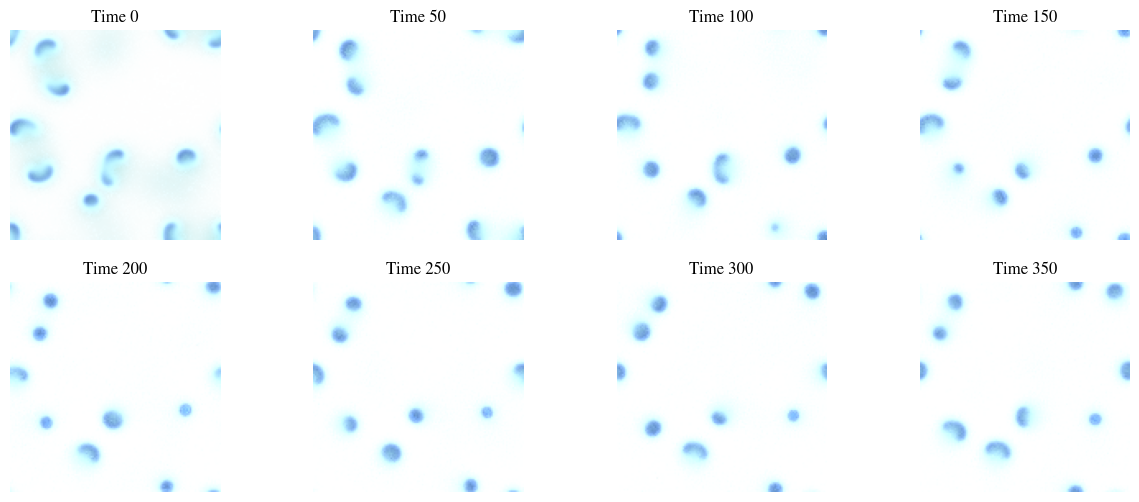

In [35]:
plt.figure(figsize=(15, 6))
plot_trace(trace_pred / 2 + 1/2, dt=50, num_rows=2, num_cols=4, name=name)
plt.show()

In [16]:
def ground_truth_simulation(name, x0, T=500, dt=1.0):
    sim = GrayScottSimulator(pattern_preset=name, device='cuda', dt=dt)
    x0 = dataset.denormalize(dataset[0].cuda())
    u, v = x0[0].unsqueeze(0), x0[1].unsqueeze(0)
    u, v = sim.forward(u, v, steps=1000, trace=True)
    trace_true = torch.cat([u, v], dim=0).permute(1,0,2,3).unsqueeze(1)
    return trace_true

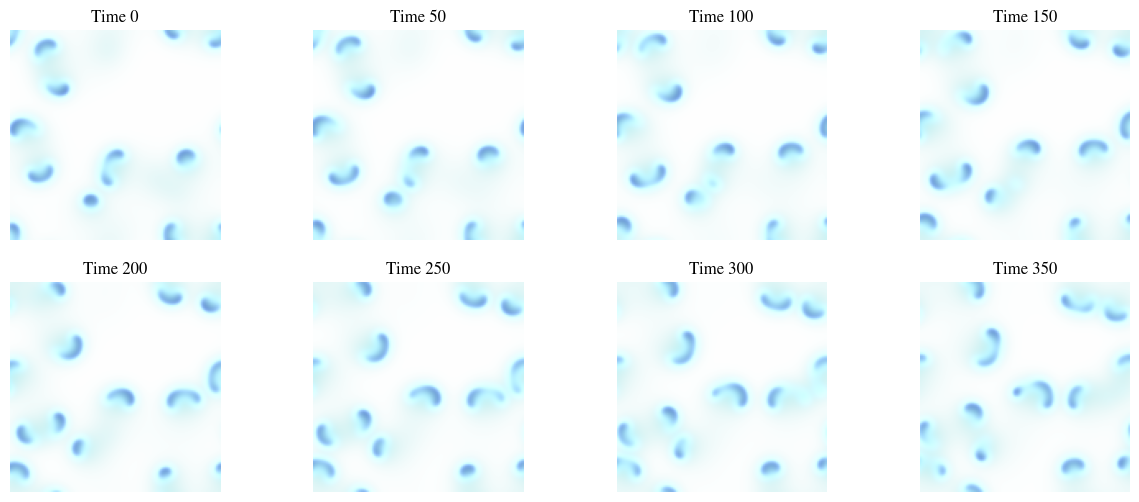

In [17]:
trace_true = ground_truth_simulation(name, x0)
plt.figure(figsize=(15, 6))
plot_trace(trace_true, dt=50, num_rows=2, num_cols=4, name=name)
plt.show()

In [44]:
dt = 0.02
eta = 0.01
paras = [
    (dt, eta, 1.0),
    (dt, eta, 0.0),
    (dt, eta, -1.0)
]
results = {}
name = 'life'
dataset, score_model, scheduler, flow_model = load_models(name, use_bn=True)
x0 = dataset[0].cuda().unsqueeze(0)

for dt, eta, v_factor in paras:
    torch.random.manual_seed(0)
    trace, trace_pred = simulate(
        x0, score_model, flow_model, scheduler,
        dt=dt, eta=eta, v_factor=v_factor, T=2000
    )
    results[(dt, eta, v_factor)] = (trace, trace_pred)

Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


 38%|███▊      | 12/32 [00:05<00:09,  2.07it/s]


KeyboardInterrupt: 

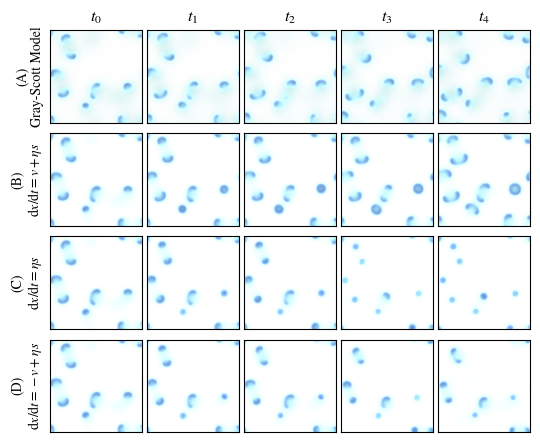

In [43]:
plotter = TuringPlotter()

plt.figure(figsize=(5.5, 4.6))

labels = ['(A)\n', '(B)\n', '(C)\n', '(D)\n']

# plot the ground-truth
for i, t in enumerate([0, 50, 100, 150, 200]):
    plt.subplot(4, 5, i + 1)
    plotter.plot(trace_true[t], name=name)
    plt.xticks([]); plt.yticks([])
    plt.title(f"$t_{i}$")
    if i == 0:
        plt.ylabel(labels[0] + "Gray-Scott Model")

# Plot the simulations

for i, ((dt, eta, v_factor), (trace, trace_pred)) in enumerate(results.items()):
    for j, t in enumerate([300 * k for k in range(5)]):
        plt.subplot(4, 5, i * 5 + j + 6)
        plotter.plot((trace_pred[t] + 1) / 2, name=name)
        plt.xticks([]); plt.yticks([])
        # plt.title(f"t={t}")
        if j == 0:
            if v_factor == 1.0:
                plt.ylabel(labels[i+1] + r"$\text{d}x / \text{d}t=v+\eta s$")
            elif v_factor == 0.0:
                plt.ylabel(labels[i+1] + r"$\text{d}x / \text{d}t=\eta s$")
            elif v_factor == -1.0:
                plt.ylabel(labels[i+1] + r"$\text{d}x / \text{d}t=-v + \eta s$")

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.01)
# plt.savefig('./figures/simulation_life.pdf', bbox_inches='tight')

In [146]:
import pickle

# save results to ./turing_pattern/data/results.pkl
with open('./turing_pattern/data/results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [37]:
name = 'life'
torch.random.manual_seed(0)
dataset, score_model, scheduler, flow_model = load_models(name, use_bn=True)
x0 = dataset[0].cuda().unsqueeze(0)
t = torch.LongTensor([10]).cuda()

Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


In [71]:
s = score_model(x0, t).sample
p = torch.randn(2, 2)
k = p - p.t()
k = k.reshape(2, 2, 1, 1)

v = nn.functional.conv2d(s, k.cuda(), padding=0)

In [92]:
trace = []; trace_pred = []
dt = 0.01; eta = 0.1; t = torch.LongTensor([50]).cuda()
x = scheduler.add_noise(x0, torch.randn_like(x0), t)

sf = score_function(score_model, scheduler, t.item())

for i in tqdm(range(100)):
    trace.append(x.cpu())
    sample = score_model(x, t).sample
    x_pred = scheduler.step(sample, t.item(), x).pred_original_sample
    trace_pred.append(x_pred.cpu().clamp(-1, 1))
    s = sf(x)
    v = nn.functional.conv2d(s, k.cuda(), padding=0)
    x = x + (v + eta * s) * dt + ((2 * eta * dt) ** 0.5) * torch.randn_like(x)

trace = torch.stack(trace, dim=0)
trace_pred = torch.stack(trace_pred, dim=0)

100%|██████████| 100/100 [00:01<00:00, 73.04it/s]


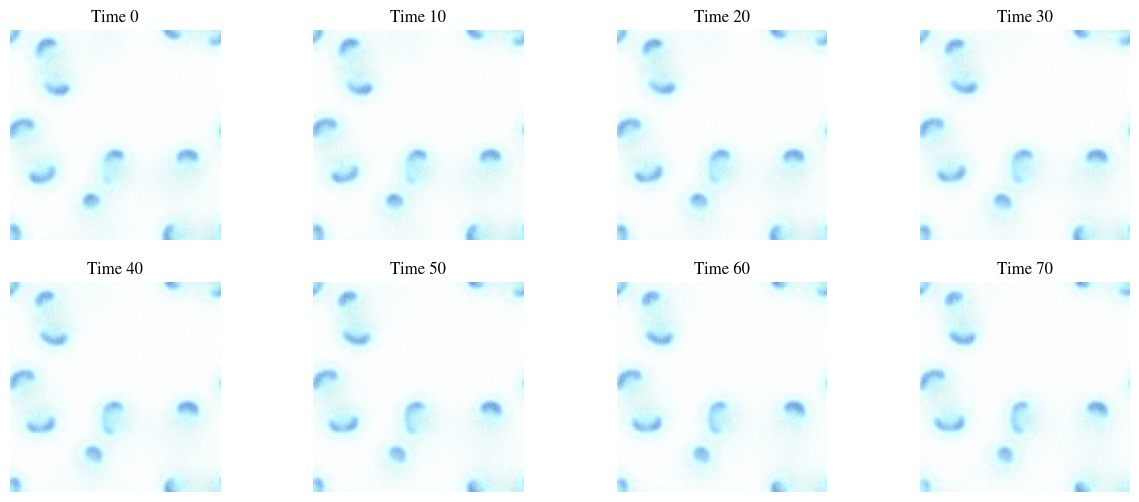

In [93]:
plt.figure(figsize=(15, 6))
plot_trace((trace_pred + 1) / 2, dt=10, num_rows=2, num_cols=4, name=name)
plt.show()